In [178]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
print( f"Python {sys.version}\nPandas {pd.__version__}\nNumPy {np.__version__}\nMatplotlib{mpl.__version__}" ) 

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
Pandas 1.3.5
NumPy 1.21.6
Matplotlib3.2.2


In [179]:
df_pm2019 = pd.read_excel('/content/drive/MyDrive/DADS/DADS5001/MiniProject/PM2.5(2019).xlsx')
df_pm2020 = pd.read_excel('/content/drive/MyDrive/DADS/DADS5001/MiniProject/PM2.5(2020).xlsx')
df_pm = pd.read_excel('/content/drive/MyDrive/DADS/DADS5001/MiniProject/PM2.5(2021).xlsx')
df_pm2 = pd.read_excel('/content/drive/MyDrive/DADS/DADS5001/MiniProject/PM2.5(2021).xlsx',sheet_name='พารามิเตอร์_สถานี')

In [180]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [181]:
pm2019 = df_pm2019.iloc[:,1:].melt().drop('variable',axis=1).rename({'value':'PM2.5(2019)'},axis=1)
pm2019 = pm2019.dropna().reset_index(drop=True)
pm2020 = df_pm2020.iloc[:,1:].melt().drop('variable',axis=1).rename({'value':'PM2.5(2020)'},axis=1)
pm2020 = pm2020.dropna().reset_index(drop=True)
pm2021 = df_pm.iloc[:,1:].melt().drop('variable',axis=1).rename({'value':'PM2.5(2021)'},axis=1)
pm2021 = pm2021.dropna().reset_index(drop=True)

In [182]:
new_df = pd.DataFrame()
new_df['2019'] = pm2019['PM2.5(2019)']
new_df['2020'] = pm2020['PM2.5(2020)']
new_df['2021'] = pm2021['PM2.5(2021)']

Text(0, 0.5, 'PM2.5(microgram/m³)')

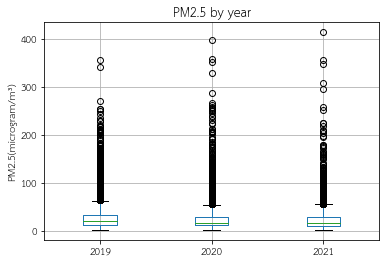

In [183]:
boxplot = new_df.boxplot(column=['2019', '2020', '2021']) 
boxplot.set_title('PM2.5 by year')
boxplot.set_ylabel('PM2.5(microgram/m³)')

In [184]:
new_df[ ['2019','2020','2021'] ].agg( ['mean','min','max'] ).round(decimals=2)

,2019,2020,2021
mean,25.84,23.76,22.49
min,2.00,2.00,2.00
max,357.00,398.00,414.00


In [185]:
#1.	Transpose dataframe ข้อมูลปริมาณฝุ่น PM2.5 เพื่อทำการ join ข้อมูลรหัสสถานีวัดฝุ่นจากอีก data sheet
df_pm_tsp = df_pm.T.reset_index(drop=False)
df_pm_tsp = df_pm_tsp.rename(columns=df_pm_tsp.iloc[0]).drop(df_pm_tsp.index[0])
# Transpose dataframe 2019
df_2019_tsp = df_pm2019.T.reset_index(drop=False)
df_2019_tsp = df_2019_tsp.rename(columns=df_2019_tsp.iloc[0]).drop(df_2019_tsp.index[0])
# Transpose dataframe 2020
df_2020_tsp = df_pm2020.T.reset_index(drop=False)
df_2020_tsp = df_2020_tsp.rename(columns=df_2020_tsp.iloc[0]).drop(df_2020_tsp.index[0])
#หาค่าเฉลี่ยของแต่ละสถานี
df_2019_tsp['Avg.pm2.5'] = df_2019_tsp.iloc[:,1:].mean(axis=1).round(decimals=2)
df_2020_tsp['Avg.pm2.5'] = df_2020_tsp.iloc[:,1:].mean(axis=1).round(decimals=2)

In [186]:
#2.	Join data จาก sheet ที่ 2 โดย merge ข้อมูลรหัสสถานีวัด
df_pm2 = df_pm2.loc[:,['รหัสสถานี','ชื่อสถานี','รายละเอียดจุดติดตั้งสถานี']]
df_pmnew = pd.merge( df_pm_tsp, df_pm2, left_on='Date', right_on='รหัสสถานี', how='outer' )
df_pmnew['Non_nan'] = df_pmnew.count(axis=1)

In [187]:
#3.	Drop column ตำแหน่งเครื่องวัดค่าฝุ่นที่มีผลการวัดน้อยกว่า 30 วัน 
filternan = df_pmnew[(df_pmnew['Non_nan'] <= 30)].index
df_pmnew.drop(filternan , inplace=True)
df_pmnew['Avg.pm2.5'] = df_pmnew.iloc[:,1:366].mean(axis=1).round(decimals=2)
avgpm_max = df_pmnew.sort_values('Avg.pm2.5',ascending = False).reset_index(drop=True)
avgpm_min = df_pmnew.sort_values('Avg.pm2.5',ascending = True)

In [188]:
def level(row):
    if row['Avg.pm2.5'] >= 0 and row['Avg.pm2.5'] <= 12:
        val = 'Good'
    elif row['Avg.pm2.5'] > 12 and row['Avg.pm2.5'] <= 35.4:
        val = 'Moderate'
    elif row['Avg.pm2.5'] > 35.4 and row['Avg.pm2.5'] <= 55.4:
        val = 'Unhealthy for sensitive'
    elif row['Avg.pm2.5'] > 55.4 and row['Avg.pm2.5'] <= 150.4:
        val = 'Unhealthy'
    elif row['Avg.pm2.5'] > 150.4 and row['Avg.pm2.5'] <= 250.4:
        val = 'Very Unhealthy'
    else:
        val = 'Hazardous'
    return val

,PM2.5 Level,2019,2020,2021
0,Moderate,59,65,75
1,Unhealthy for sensitive,5,1,1
2,Good,2,2,2


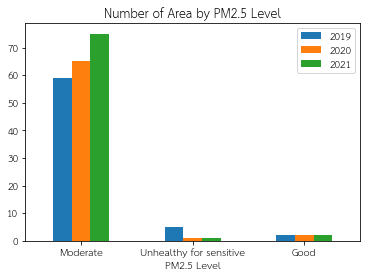

In [189]:
df_2019port =df_2019_tsp.loc[:,['Date','Avg.pm2.5']]
df_2019port['PM2.5 Level'] = df_2019port.apply(level, axis=1)
df_all2019 = df_2019port['PM2.5 Level'].value_counts().reset_index()
df_all2019.columns = ['PM2.5 Level', '2019']

df_2020port =df_2020_tsp.loc[:,['Date','Avg.pm2.5']]
df_2020port['PM2.5 Level'] = df_2020port.apply(level, axis=1)
df_all2020 = df_2020port['PM2.5 Level'].value_counts().reset_index()
df_all2020.columns = ['PM2.5 Level', '2020']

df_2021port =df_pmnew.loc[:,['รหัสสถานี','Avg.pm2.5']]
df_2021port['PM2.5 Level'] = df_2021port.apply(level, axis=1)
df_allport = df_2021port['PM2.5 Level'].value_counts().reset_index()
df_allport.columns = ['PM2.5 Level', '2021']

import functools as ft
dfs = [ df_all2019, df_all2020,df_allport]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='PM2.5 Level'), dfs)
ax = df_final.plot(x='PM2.5 Level', y=['2019','2020','2021'], kind='bar', rot=0)
ax.set_title('Number of Area by PM2.5 Level')
df_final


In [190]:
df_avgmax = avgpm_max.loc[0:4,['รหัสสถานี','ชื่อสถานี','Non_nan','Avg.pm2.5']]
df_avgmax

,รหัสสถานี,ชื่อสถานี,Non_nan,Avg.pm2.5
0,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย,364,39.59
1,18T,ต.ปากน้ำ อ.เมือง จ.สมุทรปราการ,369,33.69
2,54T,ริมถนนดินแดง แขวงดินแดง เขตดินแดง กทม.,367,32.59
3,03T,ริมถนนกาญจนาภิเษก แขวงแสมดำ เขตบางขุนเทียน กทม.,365,30.33
4,46T,ต.ในเมือง อ.เมือง จ.ขอนแก่น,355,30.10


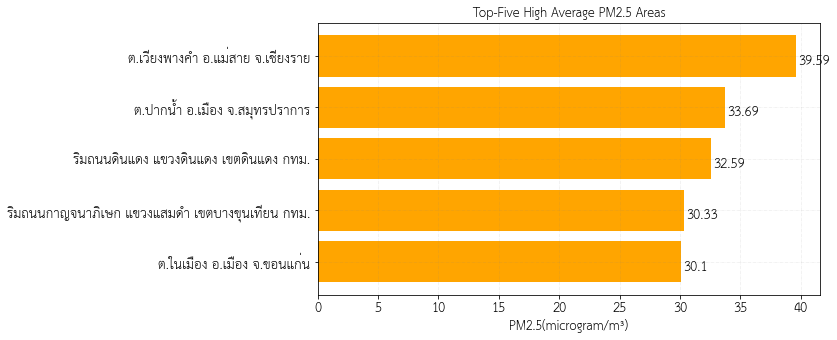

In [191]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(df_avgmax['ชื่อสถานี'],df_avgmax['Avg.pm2.5'],color='orange')
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=13, fontweight='bold',
             color='black',va='center')
    
ax.set_title('Top-Five High Average PM2.5 Areas')
ax.set_xlabel('PM2.5(microgram/m³)',fontsize=12)

plt.show()

In [192]:
df_bday = df_pmnew
df_bday['Unhealthy_Day'] = df_bday.iloc[:,1:366].ge(55).sum(axis=1)

In [193]:
df_bday['%Unhealthy_Day'] = ((df_bday['Unhealthy_Day']/df_bday['Non_nan'])*100).round(decimals=2)
df_bday = df_bday.sort_values('%Unhealthy_Day',ascending = False).reset_index(drop=True)

In [194]:
df_pmnew['Good_Day'] = df_pmnew.iloc[:,1:366].le(12).sum(axis=1)

df_gday = df_pmnew.sort_values('Good_Day',ascending = False).reset_index(drop=True)
df_gday['%Good_Day'] = ((df_gday['Good_Day']/df_gday['Non_nan'])*100).round(decimals=2)

In [195]:
df_tgday = df_gday.loc[0:9,['รหัสสถานี','ชื่อสถานี','Good_Day','%Good_Day']]
df_tgday

,รหัสสถานี,ชื่อสถานี,Good_Day,%Good_Day
0,78T,ต.เบตง อ.เบตง จ.ยะลา,279,78.37
1,82T,ต.มีชัย อ.เมือง จ.หนองคาย,250,68.68
2,84T,ต.ลาดใหญ่ อ.เมือง จ.สมุทรสงคราม,213,59.17
3,71T,ต.อรัญประเทศ อ.อรัญประเทศ จ.สระแก้ว,213,57.88
4,39T,ต.บ้านดง อ.แม่เมาะ จ.ลำปาง,206,57.22
5,80T,ต.พิมาน อ.เมือง. จ.สตูล,206,57.06
6,87T,ต.บางพระ อ.เมือง จ.ตราด,205,56.16
7,79T,ต.บ้านเหนือ อ.เมือง จ.กาญจนบุรี,201,54.77
8,38T,ต.สบป้าด อ.แม่เมาะ จ.ลำปาง,192,52.17
9,62T,ต.บางนาค อ.เมือง จ.นราธิวาส,182,49.32


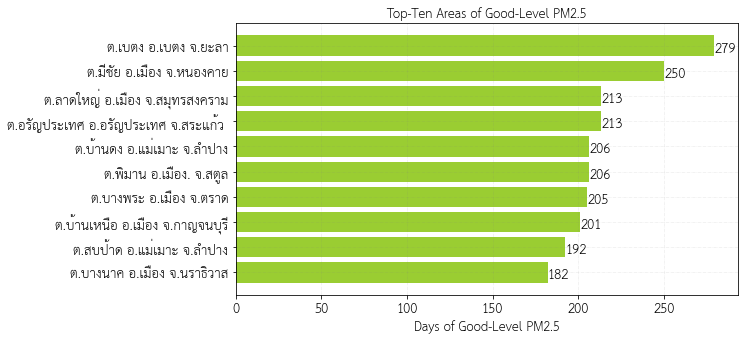

In [196]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(df_tgday['ชื่อสถานี'],df_tgday['Good_Day'],color='yellowgreen')
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=13, fontweight='bold',
             color='black',va='center')
    
ax.set_title('Top-Ten Areas of Good-Level PM2.5')
ax.set_xlabel('Days of Good-Level PM2.5',fontsize=12)

plt.show()

In [197]:
df_tbday = df_bday.loc[0:9,['รหัสสถานี','ชื่อสถานี','Unhealthy_Day','%Unhealthy_Day']]
df_tbday

,รหัสสถานี,ชื่อสถานี,Unhealthy_Day,%Unhealthy_Day
0,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย,63,17.31
1,37T,ต.พระบาท อ.เมือง จ.ลำปาง,62,16.85
2,76T,ต.แม่ปะ อ.แม่สอด จ.ตาก,53,14.72
3,39T,ต.บ้านดง อ.แม่เมาะ จ.ลำปาง,51,14.17
4,70T,ต.บ้านต๋อม อ.เมืองพะเยา จ.พะเยา,48,13.08
5,35T,ต.ช้างเผือก อ.เมือง จ.เชียงใหม่,47,12.81
6,86T,ต.ในเมือง อ.เมือง จ.พิษณุโลก,44,12.09
7,58T,ต.จองคำ อ.เมือง จ.แม่ฮ่องสอน,43,11.85
8,40T,ต.แม่เมาะ อ.แม่เมาะ จ.ลำปาง,42,11.67
9,36T,ต.ศรีภูมิ อ.เมือง จ.เชียงใหม่,41,11.17


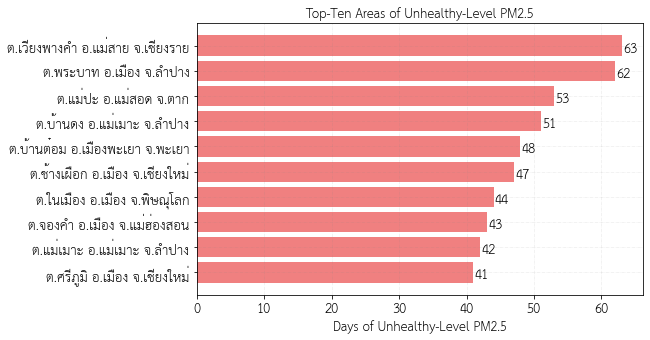

In [198]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(df_tbday['ชื่อสถานี'],df_tbday['Unhealthy_Day'],color='lightcoral')
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=13, fontweight='bold',
             color='black',va='center')
    
ax.set_title('Top-Ten Areas of Unhealthy-Level PM2.5')
ax.set_xlabel('Days of Unhealthy-Level PM2.5',fontsize=12)

plt.show()

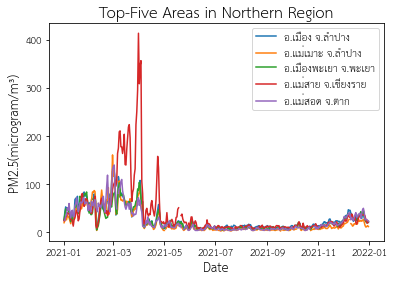

In [199]:
df_north = df_pm.loc[:,['Date','37T','39T','70T','73T','76T']]
plt.plot(df_north['Date'],df_north['37T'],label='อ.เมือง จ.ลำปาง')
plt.plot(df_north['Date'],df_north['39T'],label='อ.แม่เมาะ จ.ลำปาง')
plt.plot(df_north['Date'],df_north['70T'],label='อ.เมืองพะเยา จ.พะเยา')
plt.plot(df_north['Date'],df_north['73T'],label='อ.แม่สาย จ.เชียงราย')
plt.plot(df_north['Date'],df_north['76T'],label='อ.แม่สอด จ.ตาก')
plt.legend()
plt.ylabel('PM2.5(microgram/m³)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Top-Five Areas in Northern Region', fontsize=15)
plt.show()

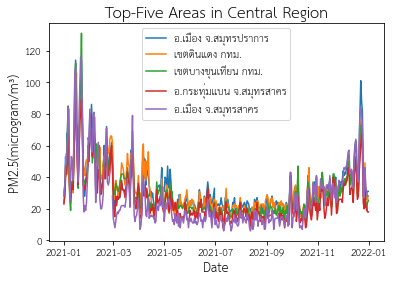

In [200]:
df_avgmax20 = avgpm_max.loc[0:19,['รหัสสถานี','ชื่อสถานี','Non_nan','Avg.pm2.5']]
df_central5 = df_pm.loc[:,['Date','18T','54T','03T','14T','27T']]

plt.plot(df_central5['Date'],df_central5['18T'],label='อ.เมือง จ.สมุทรปราการ')
plt.plot(df_central5['Date'],df_central5['54T'],label='เขตดินแดง กทม.')
plt.plot(df_central5['Date'],df_central5['03T'],label='เขตบางขุนเทียน กทม.')
plt.plot(df_central5['Date'],df_central5['14T'],label='อ.กระทุ่มแบน จ.สมุทรสาคร')
plt.plot(df_central5['Date'],df_central5['27T'],label='อ.เมือง จ.สมุทรสาคร')
plt.legend()
plt.ylabel('PM2.5(microgram/m³)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Top-Five Areas in Central Region', fontsize=15)
plt.show()

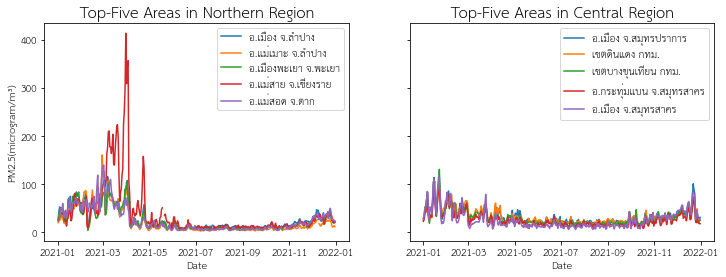

In [201]:
fig, axs = plt.subplots(nrows=1, ncols=2,sharey= True,figsize=(12,4))

axs[0].plot(df_north['Date'],df_north['37T'],label='อ.เมือง จ.ลำปาง')
axs[0].plot(df_north['Date'],df_north['39T'],label='อ.แม่เมาะ จ.ลำปาง')
axs[0].plot(df_north['Date'],df_north['70T'],label='อ.เมืองพะเยา จ.พะเยา')
axs[0].plot(df_north['Date'],df_north['73T'],label='อ.แม่สาย จ.เชียงราย')
axs[0].plot(df_north['Date'],df_north['76T'],label='อ.แม่สอด จ.ตาก')

axs[0].set_title('Top-Five Areas in Northern Region', fontsize=15)

axs[1].plot(df_central5['Date'],df_central5['18T'],label='อ.เมือง จ.สมุทรปราการ')
axs[1].plot(df_central5['Date'],df_central5['54T'],label='เขตดินแดง กทม.')
axs[1].plot(df_central5['Date'],df_central5['03T'],label='เขตบางขุนเทียน กทม.')
axs[1].plot(df_central5['Date'],df_central5['14T'],label='อ.กระทุ่มแบน จ.สมุทรสาคร')
axs[1].plot(df_central5['Date'],df_central5['27T'],label='อ.เมือง จ.สมุทรสาคร')

axs[1].set_title('Top-Five Areas in Central Region', fontsize=15)

axs[0].set_ylabel('PM2.5(microgram/m³)')
axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')
axs[0].legend()
axs[1].legend()
plt.show()